# 1. Imports & Configuration

This cell imports all necessary libraries and sets up the parameters for our simulation. By keeping all parameters in one place, we can easily tune the system's behavior and generate different datasets.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime


# --- Simulation Parameters ---
# These control the duration and resolution of our data.
t_max = 50.0          # (seconds) - Total time for the simulation.
dt = 0.05             # (seconds) - Time step for data points.
t_span = [0, t_max]   # The interval of integration.
t_eval = np.arange(0, t_max, dt) # Times at which to store the computed solution.

# --- Physics Parameters ---
# These define the physical nature of our harmonic oscillator.
omega0 = 1.0  # (rad/s) - Natural angular frequency (sqrt(k/m)). Controls the speed of oscillation.
zeta = 0.   # (dimensionless) - Damping ratio.
              #   zeta = 0   -> No damping (ideal SHO)
              #   zeta < 1   -> Underdamped (oscillates with decay)
              #   zeta = 1   -> Critically damped (fastest return to zero, no oscillation)
              #   zeta > 1   -> Overdamped (slow return to zero, no oscillation)

# --- Initial Conditions ---
# This is the state of the system at time t=0.
# Format: [initial_position, initial_velocity]
x0 = [1.0, 0.0]  # Start at position 1.0 with zero initial velocity.

print("Configuration loaded. Ready for the next step.")

Configuration loaded. Ready for the next step.


# 2. Define the Physical System 

This function translates the mathematical laws of the harmonic oscillator into a Python function that SciPy's solver can understand.

The governing **second-order ODE** is:
$$ \frac{d^2x}{dt^2} + 2\zeta\omega_0 \frac{dx}{dt} + \omega_0^2 x = 0 $$

We rewrite this as a system of two **first-order ODEs** by defining the state vector as `y = [position, velocity]`. The function will compute the derivative of this state vector: `[d(position)/dt, d(velocity)/dt]`.

In [2]:
def sho_system(t, y, zeta, omega0):
    """
    Defines the system of first-order ODEs for a damped harmonic oscillator.

    Args:
        t (float): The current time (required by solve_ivp, but not used in this system).
        y (list or np.array): A list containing the current state [position, velocity].
        zeta (float): The damping ratio.
        omega0 (float): The natural angular frequency.

    Returns:
        list: A list containing the derivatives [dx/dt, dv/dt].
    """
    position, velocity = y

    # First ODE: d(position)/dt = velocity
    dxdt = velocity

    # Second ODE: d(velocity)/dt = acceleration
    # Derived from the main equation: d²x/dt² = -2*zeta*omega0*(dx/dt) - omega0²*x
    dvdt = -2 * zeta * omega0 * velocity - omega0**2 * position

    return [dxdt, dvdt]

print("Physical system function `sho_system` is defined.")

Physical system function `sho_system` is defined.


# 3. Solve the ODE System 

Now for the main event. In this cell, we use SciPy's `solve_ivp` (Initial Value Problem) function to integrate our system of ODEs.

We pass it:
- Our `sho_system` function.
- The time interval `t_span`.
- The initial conditions `x0`.
- The specific times `t_eval` where we want to store the solution.
- Our physics parameters (`zeta`, `omega0`) using the `args` argument.

The function returns a solution object containing the results.

In [3]:
# Call the ODE solver
solution = solve_ivp(
    fun=sho_system,      # The function defining the system
    t_span=t_span,       # The [start, end] time of the integration
    y0=x0,               # The initial state [position, velocity]
    method='RK45',       # The integration method (RK45 is a good default)
    t_eval=t_eval,       # Times to store the solution at
    args=(zeta, omega0)  # Extra arguments to pass to our system function
)

# The solution object `solution.y` contains the results, with position in the
# first row and velocity in the second.
# solution.y[0] -> position array
# solution.y[1] -> velocity array

print("ODE solved successfully.")
print(f"Output solution shape (states x timesteps): {solution.y.shape}")

ODE solved successfully.
Output solution shape (states x timesteps): (2, 1000)


# 4. Structure the Data 

The output from `solve_ivp` is a pair of NumPy arrays, which is computationally efficient but not very user-friendly. 

In this step, we'll organize our results into a **Pandas DataFrame**. This is like a spreadsheet for our data, with clearly labeled columns (`time`, `position`, `velocity`). This format is standard for most data science and machine learning tasks and will be perfect for feeding into TensorFlow later.

In [4]:
# Create a dictionary to hold the solution data
data = {
    'time': solution.t,
    'position': solution.y[0],
    'velocity': solution.y[1]
}

# Create the Pandas DataFrame
df = pd.DataFrame(data)

# Display the first 5 rows to inspect the data
print("Data structured into a DataFrame. Here are the first 5 rows:")
df.head()

Data structured into a DataFrame. Here are the first 5 rows:


,time,position,velocity
0,0.00,1.000000,0.000000
1,0.05,0.998750,-0.049979
2,0.10,0.995004,-0.099833
3,0.15,0.988772,-0.149441
4,0.20,0.980072,-0.198681


# 5. Visualize the Results 

This is our crucial "sanity check." We'll plot the position and velocity over time to visually confirm that our simulation produced the expected behavior of a damped harmonic oscillator. The position should be a sine wave that gradually decays over time.

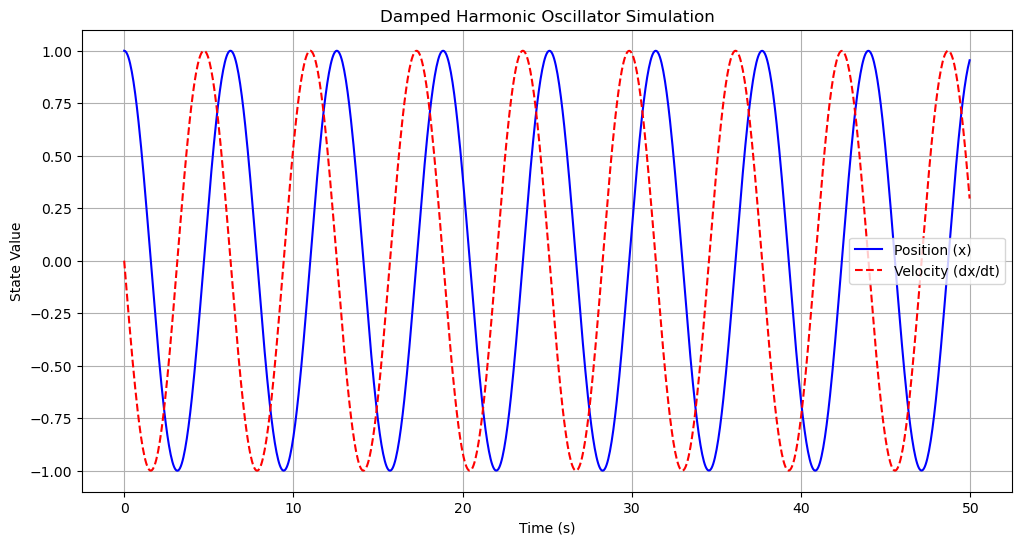

In [5]:
# Create a plot to visualize the solution
plt.figure(figsize=(12, 6))

# Plot position vs. time
plt.plot(df['time'], df['position'], label='Position (x)', color='blue')

# Plot velocity vs. time
plt.plot(df['time'], df['velocity'], label='Velocity (dx/dt)', color='red', linestyle='--')

# Add labels and a title for clarity
plt.xlabel('Time (s)')
plt.ylabel('State Value')
plt.title('Damped Harmonic Oscillator Simulation')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

# 6. Save the Ground Truth Data 💾

This final step saves our generated data for future use. The code below creates a unique, descriptive filename containing the timestamp and key simulation parameters. It then saves the data in two professional formats:

1.  **`.csv`**: A universal, human-readable format for easy inspection.
2.  **`.parquet`**: A high-performance, compressed format ideal for machine learning pipelines.

In [6]:
import os
import datetime

# --- 1. Define the output directory using a relative path ---
output_dir = '../data/processed'

# --- 2. Create a unique and descriptive filename ---
timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')
zeta_str = str(zeta).replace('.', 'p')
omega0_str = str(omega0).replace('.', 'p')
filename = f"{timestamp}_sho_zeta{zeta_str}_omega{omega0_str}.csv"

# --- 3. Create the directory if it doesn't already exist ---
output_path = os.path.join(output_dir, filename)
os.makedirs(output_dir, exist_ok=True)

# --- 4. Save the DataFrame to a CSV file ---
df.to_csv(output_path, index=False)
print(f"Data successfully saved to: {output_path}")

Data successfully saved to: ../data/processed/2025-10-09_121653_sho_zeta0p0_omega1p0.csv
